# <u><center>Detection, vectorisation, and regularisation of building foot-prints from LiDAR data</center></u>
## <center>Solution in Python 🐍 </center>

Requirements:

In [36]:
# Python version: 3.7.7
# Libraries, Modules:
import os 

try:
    from tkinter import Tk                       # tkinter 8.6
    from tkFileDialog import askopenfilenames
except:
    from tkinter import Tk
    from tkinter import filedialog
    
import numpy as np                               # numpy 1.21.6
import matplotlib.pyplot as plt                  # matplotlib 3.5.3
import pandas as pd                              # pandas 1.3.5
import geopandas as gpd                          # geopandas 0.9.0
import laspy                                     # laspy 2.4.1
from shapely.geometry import Polygon, MultiPolygon # shapely 1.8.4
from osgeo import gdal                           # osgeo 3.0.2
import cvxpy as cp                               # cpxpy 1.3.2
import scipy as scipy                            # scipy 1.7.3
import cvxopt as cvxopt                          # cvxopt 1.3.2
import shapely
from shapely import speedups
import math
import statistics

In [19]:
CurrentDirectory = os.getcwd()

#### Choosing of *.las files
(MacOS)

In [2]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filenames = filedialog.askopenfilenames() # show an "Open" dialog box and return the path to the selected file
filenames = [s for s in filenames if (s[-4:]=='.las')]
print (f'\033[1;30;42m {filenames}\033[0;0m')

 ['/Users/tomasic/Desktop/Ident_budovy/data/Lidar_sídlisko/03_Bratislava_17_205026_5342423_a_c_jtsk03_bpv_clip.las', '/Users/tomasic/Desktop/Ident_budovy/data/Lidar_sídlisko/03_Bratislava_17_204816_5345930_a_c_jtsk03_bpv_clip.las', '/Users/tomasic/Desktop/Ident_budovy/data/Lidar_sídlisko/03_Bratislava_17_204623_5342447_a_c_jtsk03_bpv_clip.las', '/Users/tomasic/Desktop/Ident_budovy/data/Lidar_sídlisko/03_Bratislava_17_204416_5346010_a_c_jtsk03_bpv_clip.las']


#### import LiDAR data

In [13]:
df_las_XYZ = pd.DataFrame(columns=['X','Y','Z'])

for i in filenames:
    las = laspy.read(i)
    new_file = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
    new_file.points = las.points[las.classification == 6] # select which class of building
    scale, offset = las.header.scale, las.header.offset
    df2 = pd.DataFrame({'X':(new_file['X']*scale[0])+ offset[0],'Y':(new_file['Y']*scale[1])+ offset[1],'Z':(new_file['Z']*scale[2])+ offset[2]})
    df_las_XYZ = df_las_XYZ.append(df2)
gdf_las_XYZ = gpd.GeoDataFrame(df_las_XYZ, geometry=gpd.points_from_xy(df_las_XYZ.X, df_las_XYZ.Y), crs="EPSG:8353") # define EPSG of CRS for data

# Bounding box
bbox_las = (df_las_XYZ.X.min(), df_las_XYZ.Y.min(), df_las_XYZ.X.max(), df_las_XYZ.Y.max()) # coordinates of window: left upper corner, right lower corner
bbox_ran = (abs(df_las_XYZ.X.min()- df_las_XYZ.X.max()), abs(df_las_XYZ.Y.min()- df_las_XYZ.Y.max())) # the range of window in directions X, Y

# Data structure prepating
filenames1 = []
df_b_clip = pd.DataFrame(columns=['Geom'])

if filenames1 != []:
    b_clip_shpDirectory = os.path.dirname(filenames1[0])
    os.chdir(b_clip_shpDirectory)
    b_clip_name = os.path.basename(filenames1[0])
    b_clip = pd.DataFrame([pt for pt in fiona.open(b_clip_name)])['geometry']
    df_b_clip = df_b_clip.append({'Geom': Polygon(b_clip[0]['coordinates'][0])}, ignore_index = True)
    gdf_b_clip = gpd.GeoDataFrame(df_b_clip, crs="EPSG:8353", geometry='Geom')
    gdf = gdf_las_XYZ.clip(gdf_b_clip)
    
else:
    df_b_clip = df_b_clip.append({'Geom': Polygon([(bbox_las[0],bbox_las[1]),(bbox_las[0],bbox_las[3]),(bbox_las[2],bbox_las[3]), (bbox_las[2],bbox_las[1])])}, ignore_index = True)
    gdf_b_clip = gpd.GeoDataFrame(df_b_clip, crs="EPSG:8353", geometry='Geom')
    gdf = gdf_las_XYZ

#### Clusterisation of LiDAR points by HDBSCAN alg.
- https://hdbscan.readthedocs.io/en/latest/

In [15]:
%%time
import hdbscan  
#gdf=gdfz
hdbscan = hdbscan.HDBSCAN(min_cluster_size=30, min_samples = 1, cluster_selection_epsilon = 0.3,cluster_selection_method = 'leaf')#, cluster_selection_epsilon = 0.4)
labels = hdbscan.fit_predict(np.array(gdf[['X','Y']]))

CPU times: user 2.63 s, sys: 390 ms, total: 3.02 s
Wall time: 4.59 s


In [16]:
gdf['Cluster'] = labels

gdf = gdf.drop(gdf.index[gdf['Cluster']==-1]) # removing of non-classified points

df_max = pd.DataFrame() # list of highest points from each cluster 
df_max = df_max.append([gdf[(gdf['Cluster']== i) & (gdf['Z']== max(gdf[gdf['Cluster']== i]['Z']))] for i in np.unique(gdf['Cluster'])])
df_max = df_max.set_index('Cluster')
gdf_max = gpd.GeoDataFrame(df_max, geometry= gpd.points_from_xy(df_max.X, df_max.Y), crs="EPSG:8353")

#### Polygonization of clusters by Concave_Hull alg.
Taken from:
- https://github.com/dkalinina/Concave_Hull

In [21]:
%%time
gdfn = gdf
# import externého modulu
AlfashapeDirectory = CurrentDirectory + '/alfashape_script'
os.chdir(AlfashapeDirectory)

# funkcia polygonizácie mračna bodov
def ccv_hull(pp,parameter=0.758):              # pp -> mračno bodov | parameter -> koeficient podrobnosti modelovania hranice polygonu 0.758
    from alfashape import getAlfaShapes

    pts = [(float(x[0]), float(x[1])) for x in pp]
    params = [parameter]
    lines = getAlfaShapes(pts, alfas=params)
    line = np.array(lines[0][0])
    return line                              # návratová hodnota -> zoznam po sebe idúcich bodov tvoriace hranicu vstupného mračna bodov



df_lid = pd.DataFrame(columns=['Geom'])

for i in np.unique(gdfn['Cluster']):
    build = ccv_hull(np.array([gdfn.loc[gdfn['Cluster']==i]['X'],gdfn.loc[gdfn['Cluster']==i]['Y']]).T)
    #print(i)
    d = {'Geom': Polygon([(float(x[0]), float(x[1])) for x in build])}
    df_lid = df_lid.append(d, ignore_index = True)
    
gdf_lid = gpd.GeoDataFrame(df_lid, crs="EPSG:8353", geometry='Geom')
gdf_lid['Cluster']=np.unique(gdfn['Cluster'])

CPU times: user 4.56 s, sys: 204 ms, total: 4.77 s
Wall time: 4.88 s


#### Filtering building polygons by minimal height criteria

In [24]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx


df_max = pd.DataFrame() # bod s najäčšou výškou v každom clustri bodov
df_max = df_max.append([gdfn[(gdfn['Cluster']== i) & (gdfn['Z']== max(gdfn[gdfn['Cluster']== i]['Z']))] for i in np.unique(gdfn['Cluster'])])
df_max = df_max.set_index('Cluster')
gdf_max = gpd.GeoDataFrame(df_max, geometry= gpd.points_from_xy(df_max.X, df_max.Y), crs="EPSG:8353")


filename = CurrentDirectory + '/dmr.tif'
gdal_data = gdal.Open(filename)
dem = gdal_data.ReadAsArray()
gt = gdal_data.GetGeoTransform()

Xi = np.arange(gt[0], gt[0] + dem.shape[1]*(gt[1]), gt[1])
Yi = np.arange(gt[3], gt[3] + dem.shape[0]*(gt[5]), gt[5])

dem_list = []

for i in range(0,len(df_max),1):
    dem_list.append(dem[find_nearest(Yi, list(df_max.iloc[[i]].Y)), find_nearest(Xi, list(df_max.iloc[[i]].X))])

df_max['elev'] = df_max.Z - dem_list

height = 2 # minimum height over surface [m]

del_clus = np.unique(df_max.index[df_max['elev']<= height])
gdf_lid = gdf_lid.drop(del_clus)

#### Filtering building polygons by minimal area criteria

In [25]:
area = 5
gdf_lid['Area'] = gdf_lid.area
gdf_lid = gdf_lid.drop(gdf_lid.index[gdf_lid['Area'] <= area])

#### Function for polygons simplification/smoothing of edges by L1 Trend Filtering alg.
Taken from:
- https://www.cvxpy.org/examples/applications/l1_trend_filter.html

In [27]:
def L1tf(polygon,d,L=2):
    y = np.array(polygon[:-1,d])
    n = y.size
    
    uu = [((polygon[i,0]-polygon[i+1,0])**2+(polygon[i,1]-polygon[i+1,1])**2)**(1/2) for i in range(len(polygon)-1)]
    u = [0]*(len(polygon)-1)

    for i in range(1,len(uu)-1):
        u[i] = u[i-1]+uu[i-1]
        
    u = np.array(u)

    # Form second difference matrix.
    e = np.ones((1, n))
    D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)

    # Set regularization parameter.
    vlambda = L

    # Solve l1 trend filtering problem.
    x = cp.Variable(shape=n,value=u)
    obj = cp.Minimize(0.5 * cp.sum_squares(y - x) + vlambda * cp.norm(D*x, 1) )
    prob = cp.Problem(obj)

    # ECOS and SCS solvers fail to converge before
    # the iteration limit. Use CVXOPT instead.
    
    #prob.solve(solver=cp.CVXOPT, verbose=True)
    #prob.solve(solver=cp.CVXOPT, verbose=False, max_iters=5000)
    prob.solve(solver=cp.ECOS, verbose=False)
    #prob.solve(solver=cp.SCS, verbose=False)
    return x

#### Function of shape similarity index

In [28]:
def calculate_SSI(polygon1, polygon2):
    # Výpočet charakteristík polygónov
    area1 = polygon1.area
    perimeter1 = polygon1.length
    centroid1 = polygon1.centroid
    
    area2 = polygon2.area
    perimeter2 = polygon2.length
    centroid2 = polygon2.centroid
    
    # Normalizácia charakteristík
    normalized_area1 = area1 / max(area1, area2)
    normalized_perimeter1 = perimeter1 / max(perimeter1, perimeter2)
    normalized_centroid1 = centroid1.coords[0]
    
    normalized_area2 = area2 / max(area1, area2)
    normalized_perimeter2 = perimeter2 / max(perimeter1, perimeter2)
    normalized_centroid2 = centroid2.coords[0]
    
    # Výpočet podobnosti
    similarity_score = (
        abs(normalized_area1 - normalized_area2) +
        abs(normalized_perimeter1 - normalized_perimeter2) +
        abs(normalized_centroid1[0] - normalized_centroid2[0]) +
        abs(normalized_centroid1[1] - normalized_centroid2[1])
    ) / 4
    
    # Hodnotenie podobnosti
    SSI = 1 - similarity_score 
    return SSI

#### Function for polygons ortogonalization
Taken from:
- https://github.com/Mashin6/orthogonalize-polygon

In [30]:
%%time
speedups.enable()

def needle_rem(buildings):
    ax,ay = np.array(buildings.exterior.xy)
    ax, ay = np.hstack((ax,ax[1])), np.hstack((ay,ay[1]))

    row_i = np.full(len(ax)-2, False, dtype=bool)
    for i in range(1,len(ax)-1):
        sl1 = (ax[i-1]-ax[i])/(ay[i-1]-ay[i])
        sl2 = (ax[i+1]-ax[i])/(ay[i+1]-ay[i])
        if round(sl1,4)==round(sl2,4):
            row_i[i-1] = True

    ax1, ay1 = np.delete(ax[1:-1], row_i, axis=0), np.delete(ay[1:-1], row_i, axis=0)        
    return Polygon(zip(ax1,ay1)) 

def calculate_SSI(polygon1, polygon2):
    # Výpočet charakteristík polygónov
    area1 = polygon1.area
    perimeter1 = polygon1.length
    centroid1 = polygon1.centroid
    
    area2 = polygon2.area
    perimeter2 = polygon2.length
    centroid2 = polygon2.centroid
    
    # Normalizácia charakteristík
    normalized_area1 = area1 / max(area1, area2)
    normalized_perimeter1 = perimeter1 / max(perimeter1, perimeter2)
    normalized_centroid1 = centroid1.coords[0]
    
    normalized_area2 = area2 / max(area1, area2)
    normalized_perimeter2 = perimeter2 / max(perimeter1, perimeter2)
    normalized_centroid2 = centroid2.coords[0]
    
    # Výpočet podobnosti
    similarity_score = (
        abs(normalized_area1 - normalized_area2) +
        abs(normalized_perimeter1 - normalized_perimeter2) +
        abs(normalized_centroid1[0] - normalized_centroid2[0]) +
        abs(normalized_centroid1[1] - normalized_centroid2[1])
    ) / 4
    
    # Hodnotenie podobnosti
    SSI = 1 - similarity_score 
    """print(abs(normalized_area1 - normalized_area2) ,
        abs(normalized_perimeter1 - normalized_perimeter2) ,
        abs(normalized_centroid1[0] - normalized_centroid2[0]) ,
        abs(normalized_centroid1[1] - normalized_centroid2[1]))
    print(centroid1,centroid2)"""
    return SSI

#########

def calculate_initial_compass_bearing(pointA, pointB): #vyrára smerník 
    """
    Calculates the bearing between two points.

    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))

    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees

    :Returns:
      The bearing in degrees

    :Returns Type:
      float
    """
    """if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))"""

    y,x = pointA[0]-pointB[0],pointA[1]-pointB[1]
    initial_bearing = math.atan2(x, y)
    
    #initial_bearing = math.atan2(pointB[0]-pointA[0],pointB[1]-pointA[1])+90

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing
    


def calculate_segment_angles(polySimple, maxAngleChange = 45):
    """
    Calculates angles of all polygon segments to cardinal directions.

    :Parameters:
      - `polySimple: shapely polygon object containing simplified building.
      - `maxAngleChange: angle (0,45> degrees. Sets the maximum angle deviation
                         from the cardinal direction for the segment to be still 
                         considered to continue in the same direction as the 
                         previous segment.

    :Returns:
      - orgAngle: Segments bearing
      - corAngle: Segments angles to closest cardinal direction
      - dirAngle: Segments direction [N, E, S, W] as [0, 1, 2, 3]

    :Returns Type:
      list
    """
    # Convert limit angle to angle for subtraction
    maxAngleChange = 45 - maxAngleChange

    # Get points Lat/Lon
    simpleX = polySimple.exterior.xy[0]
    simpleY = polySimple.exterior.xy[1]

    # Calculate angle to cardinal directions for each segment of polygon
    orgAngle = [] # Original angles
    corAngle = [] # Correction angles used for rotation
    dirAngle = [] # 0,1,2,3 = N,E,S,W
    limit = [0] * 4

    for i in range(0, (len(simpleX) - 1)):
        point1 = (simpleY[i], simpleX[i])
        point2 = (simpleY[i+1], simpleX[i+1])
        angle = calculate_initial_compass_bearing(point1, point2)

        if angle > (45 + limit[1]) and angle <= (135 - limit[1]):
            orgAngle.append(angle)
            corAngle.append(angle - 90)
            dirAngle.append(1)

        elif angle > (135 + limit[2]) and angle <= (225 - limit[2]):
            orgAngle.append(angle)
            corAngle.append(angle - 180)
            dirAngle.append(2)

        elif angle > (225 + limit[3]) and angle <= (315 - limit[3]):
            orgAngle.append(angle)
            corAngle.append(angle - 270)
            dirAngle.append(3)

        elif angle > (315 + limit[0]) and angle <= 360:
            orgAngle.append(angle)
            corAngle.append(angle - 360)
            dirAngle.append(0)

        elif angle >= 0 and angle <= (45 - limit[0]):
            orgAngle.append(angle)
            corAngle.append(angle)
            dirAngle.append(0)


        limit = [0] * 4
        limit[ dirAngle[i] ] = maxAngleChange               # Set angle limit for the current direction
        limit[ (dirAngle[i] + 1) % 4 ] = -maxAngleChange    # Extend the angles for the adjacent directions
        limit[ (dirAngle[i] - 1) % 4 ] = -maxAngleChange

    return orgAngle, corAngle, dirAngle



def rotate_polygon(polySimple, angle):
    """
    Rotates polygon around its centroid for given angle.

    :Parameters:
      - `polySimple: shapely polygon object containing simplified building.
      - `angle: angle of rotation in decimal degrees.  
                Positive = counter-clockwise, Negative = clockwise 

    :Returns:
      - bSR: rotated polygon

    :Returns Type:
      shapely Polygon
    """
    # Create WGS84 referenced GeoSeries
    bS = gpd.GeoDataFrame({'geometry':[polySimple]})
    bS.crs = "EPSG:4326"

    # Temporary reproject to Merkator and rotate by median angle
    bSR = bS.to_crs('epsg:4326')#3857
    bSR = bSR.rotate(angle, origin='centroid', use_radians=False) 
    bSR = bSR.to_crs('epsg:4326')

    # Extract only shapely polygon object
    bSR = bSR[0]

    return bSR


def orthogonalize_polygon(polygon, maxAngleChange = 12, skewTolerance = 1):
    """
    Master function that makes all angles in polygon outer and inner rings either 90 or 180 degrees.
    Idea adapted from JOSM function orthogonalize
    1) Calculate bearing [0-360 deg] of each polygon segment
    2) From bearing determine general direction [N, E, S ,W], then calculate angle deviation from nearest cardinal direction for each segment
    3) Rotate polygon by median deviation angle to align segments with xy coord axes (cardinal directions)
    4) For vertical segments replace X coordinates of their points with mean value
       For horizontal segments replace Y coordinates of their points with mean value
    5) Rotate back

    :Parameters:
      - `polygon: shapely polygon object containing simplified building.
      - `maxAngleChange: angle (0,45> degrees. Sets the maximum angle deviation
                         from the cardinal direction for the segment to be still 
                         considered to continue in the same direction as the 
                         previous segment.
      - `skewTolerance: angle <0,45> degrees. Sets skew tolerance for segments that 
                        are at 45˚±Tolerance angle from the overal rectangular shape 
                        of the polygon. Usefull when preserving e.g. bay windows on a 
                        house.

    :Returns:
      - polyOrthog: orthogonalized shapely polygon where all angles are 90 or 180 degrees

    :Returns Type:
      shapely Polygon
    """
    # Check if polygon has inner rings that we want to orthogonalize as well
    rings = [ Polygon(polygon.exterior) ]
    for inner in list(polygon.interiors):
        rings.append(Polygon(inner))


    polyOrthog = [] 
    for polySimple in rings:

        # Get angles from cardinal directions of all segments
        orgAngle, corAngle, dirAngle = calculate_segment_angles(polySimple)

        # Calculate median angle that will be used for rotation
        if statistics.stdev(corAngle) < 30:
            medAngle = statistics.median(corAngle)
            #avAngle = statistics.mean(corAngle)
        else:
            medAngle = 45  # Account for cases when building is at ~45˚ and we can't decide if to turn clockwise or anti-clockwise
        
        # Rotate polygon to align its edges to cardinal directions
        polySimpleR = rotate_polygon(polySimple, medAngle)
        
        # Get directions of rotated polygon segments
        orgAngle, corAngle, dirAngle = calculate_segment_angles(polySimpleR, maxAngleChange)

        # Get Lat/Lon of rotated polygon points
        rotatedX = polySimpleR.exterior.xy[0].tolist()
        rotatedY = polySimpleR.exterior.xy[1].tolist()

        # Scan backwards to check if starting segment is a continuation of straight region in the same direction
        shift = 0
        for i in range(1, len(dirAngle)):
            if dirAngle[0] == dirAngle[-i]:
                shift = i
            else:
                break
        # If the first segment is part of continuing straight region then reset the index to its beginning
        if shift != 0:
            dirAngle  = dirAngle[-shift:] + dirAngle[:-shift]
            orgAngle  = orgAngle[-shift:] + orgAngle[:-shift]
            rotatedX = rotatedX[-shift-1:-1] + rotatedX[:-shift]    # First and last points are the same in closed polygons
            rotatedY = rotatedY[-shift-1:-1] + rotatedY[:-shift]

        # Fix 180 degree turns (N->S, S->N, E->W, W->E)
        # Subtract two adjacent directions and if the difference is 2, which means we have 180˚ turn (0,1,3 are OK) then use the direction of the previous segment
        dirAngleRoll = dirAngle[1:] + dirAngle[0:1]
        dirAngle = [ dirAngle[i-1] if abs(dirAngle[i]-dirAngleRoll[i])==2 else dirAngle[i] for i in range(len(dirAngle)) ]

        # Cycle through all segments
        # Adjust points coodinates by taking the average of points in segment
        dirAngle.append(dirAngle[0]) # Append dummy value
        orgAngle.append(orgAngle[0]) # Append dummy value
        segmentBuffer = [] # Buffer for determining which segments are part of one large straight line 

        for i in range(0, len(dirAngle) - 1):
            # Preserving skewed walls: Leave walls that are obviously meant to be skewed 45˚+/- tolerance˚ (e.g.angle 30-60 degrees) off main walls as untouched
            if orgAngle[i] % 90 > (45 - skewTolerance) and orgAngle[i] % 90 < (45 + skewTolerance):
                continue

            # Dealing with adjacent segments following the same direction
            segmentBuffer.append(i) 
            if dirAngle[i] == dirAngle[i + 1]: # If next segment is of same orientation, we need 180 deg angle for straight line. Keep checking.
                if orgAngle[i + 1] % 90 > (45 - skewTolerance) and orgAngle[i + 1] % 90 < (45 + skewTolerance):
                    pass
                else:
                    continue

            if dirAngle[i] in {0, 2}:   # for N,S segments avereage x coordinate
                tempX = statistics.mean( rotatedX[ segmentBuffer[0]:segmentBuffer[-1]+2 ] )
                # Update with new coordinates
                rotatedX[ segmentBuffer[0]:segmentBuffer[-1]+2 ] = [tempX] * (len(segmentBuffer) + 1)  # Segment has 2 points therefore +1
            elif dirAngle[i] in {1, 3}:  # for E,W segments avereage y coordinate 
                tempY = statistics.mean( rotatedY[ segmentBuffer[0]:segmentBuffer[-1]+2 ] )
                # Update with new coordinates
                rotatedY[ segmentBuffer[0]:segmentBuffer[-1]+2 ] = [tempY] * (len(segmentBuffer) + 1)
            
            if 0 in segmentBuffer:  # Copy change in first point to its last point so we don't lose it during Reverse shift
                rotatedX[-1] = rotatedX[0]
                rotatedY[-1] = rotatedY[0]
            
            segmentBuffer = []
        

        # Reverse shift so we get polygon with the same start/end point as before
        if shift != 0:
            rotatedX = rotatedX[shift:] + rotatedX[1:shift+1]    # First and last points are the same in closed polygons
            rotatedY = rotatedY[shift:] + rotatedY[1:shift+1]
        else:
            rotatedX[0] = rotatedX[-1]    # Copy updated coordinates to first node
            rotatedY[0] = rotatedY[-1]

        # Create polygon from new points
        polyNew = Polygon(zip(rotatedX, rotatedY))
        
        # Rotate polygon back
        polyNew = rotate_polygon(polyNew, -medAngle)
        
        # Add to list of finihed rings
        polyOrthog.append(polyNew)

    # Recreate the original object
    polyOrthog = Polygon(polyOrthog[0].exterior, [inner.exterior for inner in polyOrthog[1:]])
    return polyOrthog



## Main part
l1=0.5 # parameter to L1tf function
## Orthogonalize buildings
buildings = gdf_lid.reset_index(drop=True).copy()
buildings.crs = "EPSG:4326"
buildings = buildings.rename(columns={'Geom': 'geometry'})
fl = np.full(len(buildings), False, dtype=bool)
spl = 0.35 # parameter to function .simplify(spl) 

for i in range(0, len(buildings)):
    polygon = np.array(buildings.geometry[i].boundary.xy).T
    x2, y2 = np.array(L1tf(polygon,0,l1).value),np.array(L1tf(polygon,1,l1).value)
    build = Polygon([(x2[i], y2[i]) for i in range(len(x2))]).simplify(spl)
    
    # When the condition for the SSI is not met, the parameters will be iteratively adjusted until the building shape's ISS satisfies the condition specified by ISS        
    try:
        buildOrtho = needle_rem(orthogonalize_polygon(build))
        spli=spl-0.2 # set lower initial value for parameter spl
        temp_ssi = calculate_SSI(buildings.loc[i, 'geometry'], buildOrtho)
        temp_buildOrto = buildOrtho
        
        while calculate_SSI(buildings.loc[i, 'geometry'], buildOrtho)<=0.9: # 0.9 threshold value of the SSI condition 
            t_maxAngleChange = 8 # set lower initial value for parameter t_maxAngleChange
            build = Polygon([(x2[i], y2[i]) for i in range(len(x2))]).simplify(spli)
            while calculate_SSI(buildings.loc[i, 'geometry'], buildOrtho)<=0.9 and t_maxAngleChange <=24:
                print(i, spli, t_maxAngleChange)
                t_maxAngleChange += 4 # step of change for parameter t_maxAngleChange 
                temp_ssi = calculate_SSI(buildings.loc[i, 'geometry'], buildOrtho)
                buildOrtho = needle_rem(orthogonalize_polygon(build,maxAngleChange = t_maxAngleChange))

                if temp_ssi < calculate_SSI(buildings.loc[i, 'geometry'], buildOrtho):
                    temp_buildOrto = buildOrtho
            
            spli+=0.05# step of change for parameter spli 
            
            if spli > 1: # max value of the spli value 
                buildOrtho = temp_buildOrto
                break
        
        buildings.loc[i, 'geometry'] = buildOrtho
    
    except ValueError:
        fl[i] = True

rows_to_drop = np.where(fl)[0]
buildings = buildings.drop(rows_to_drop)#.reset_index(drop=True) 

/opt/anaconda3/envs/enviGIS/lib/python3.7/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/enviGIS/lib/python3.7/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWar

CPU times: user 639 ms, sys: 27.1 ms, total: 666 ms
Wall time: 693 ms


/opt/anaconda3/envs/enviGIS/lib/python3.7/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 11 times so far.

  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/enviGIS/lib/python3.7/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 12 times so far.

  warnings.warn(msg, UserW

'b_out_w = buildings.copy()\nb_out_w.rename_geometry(\'Geom\',inplace=True)\nb_out_w.drop(columns=[\'coord\'], axis=1, inplace=True)\nb_out_w.crs = 5514\nb_out_w.to_file(\'/Users/tomasic/Desktop/Ident_budovy/data/OUTPUTS_geojson/dubravka_budovy_spracovane_oprava.geojson\', driver="GeoJSON") '

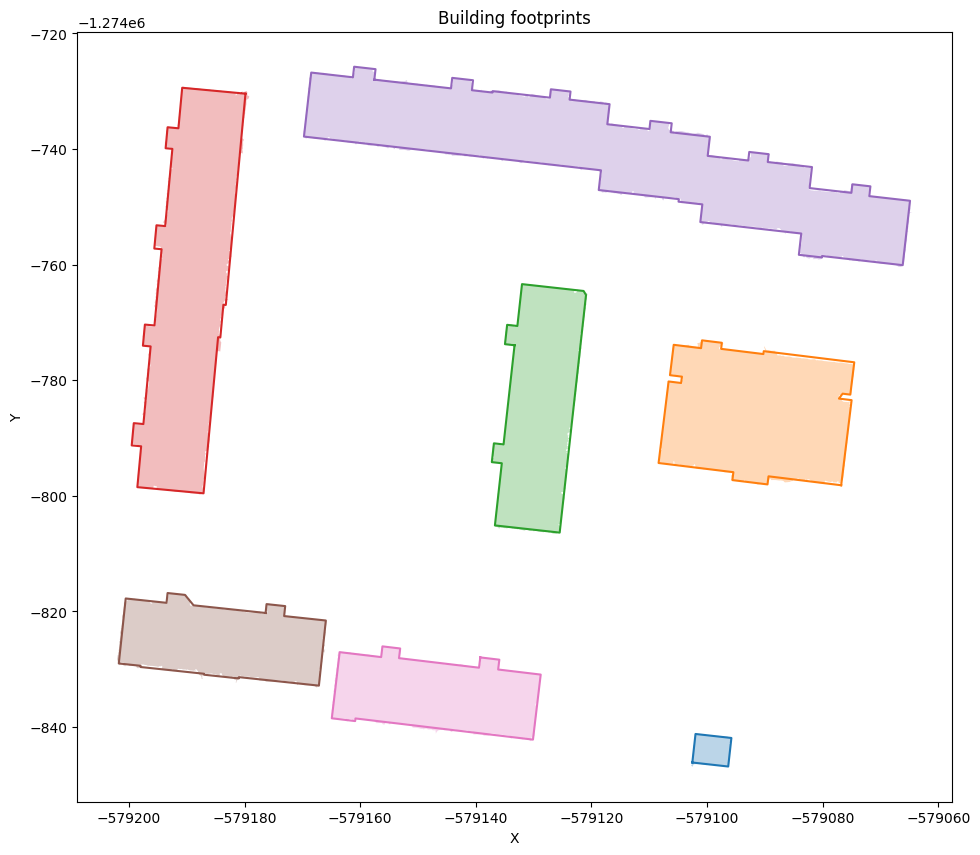

In [35]:
# Plotting of building footprints
#%matplotlib widget
fig, ax = plt.subplots(figsize=(14,10))

for i in buildings.index.values:
    yy = buildings.loc[i, 'geometry']
    yye = gdf_lid.reset_index(drop=True).copy().loc[i, 'Geom']
    xwe, ywe = yye.exterior.xy
    xw, yw = yy.exterior.xy

    ax.plot(xw, yw)
    ax.fill(xwe, ywe, alpha=0.3) 
ax.set_title('Building footprints')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

plt.show()

#### Export building footprint to geojson file

In [ ]:
b_out_w = buildings.copy()
b_out_w.rename_geometry('Geom',inplace=True)
b_out_w.drop(columns=['coord'], axis=1, inplace=True)
b_out_w.crs = 5514 #CRS -> EPSG code
b_out_w.to_file(CurrentDirectory+'/building_footprints.geojson', driver="GeoJSON")